### Generate the estimated gravitational waveform and calculate the signal-to-noise for LVT151012 ###

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

In [2]:
# Make a template from the public parameters from the LOSC and filter 
# the data to get the phase difference.
from pycbc.waveform import get_fd_waveform
z = 0.20
m1 = 23 * (1 + z) 
m2 = 13 * (1 + z)
time = 1128678900.44
hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=m1, mass2=m2, delta_f=1.0/32, f_lower=20)

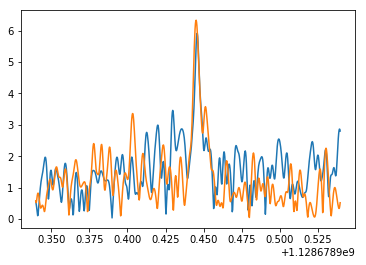

In [3]:
# Calculate the SNR in both the L1 and H1 gravitational-wave detectors
# See that there is a peak in the SNR near the same time.
%matplotlib inline
import pylab
from pycbc.filter import highpass_fir
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, welch
from pycbc.catalog import Merger

for ifo in ['L1', 'H1']:
    # Read in the data into a TimeSeries
    ts = highpass_fir(Merger("LVT151012").strain(ifo), 15, 16)

    # Estimate the noise spectrum
    psd = interpolate(welch(ts), 1.0 / ts.duration)
    
    # Calculate the signal-to-noise
    hp.resize(len(ts) / 2 + 1)
    snr = matched_filter(hp, ts, psd=psd, low_frequency_cutoff=30.0)

    # Choose the +-100ms around the event.
    i = int((time - snr.start_time) / snr.delta_t)
    snr = snr[int(i - snr.sample_rate * .1):int(i + snr.sample_rate * .1)]
    
    pylab.plot(snr.sample_times, abs(snr))